In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('train_cleaned.csv')

In [4]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,DEFAULTED,BILL_MEAN,PAY_AMT_MEAN
0,360000,female,university,single,25,0,0,8557.666667,9574.666667
1,240000,female,graduate school,single,46,2,0,1107.333333,1263.500000
2,320000,female,university,married,41,0,0,41459.666667,2750.000000
3,50000,female,university,single,24,0,1,445.833333,0.000000
4,80000,male,high school,married,52,0,0,22841.000000,1308.833333


In [5]:
# Classify the columns
categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0']
numerical = ['LIMIT_BAL', 'AGE','BILL_MEAN','PAY_AMT_MEAN']
target = 'DEFAULTED'

# Split the Data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df.drop('DEFAULTED',axis=1)
y = df['DEFAULTED']

In [8]:
X_fulltrain, X_test, y_fulltrain,y_test = train_test_split(X,y,test_size=0.2)
X_train, X_val, y_train,y_val = train_test_split(X_fulltrain,y_fulltrain,test_size=0.25)

In [9]:
X_train.reset_index(inplace=True,drop=True)
X_val.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

# Feature Engineering

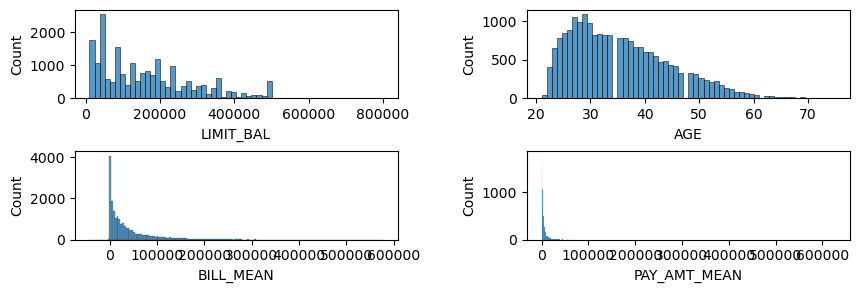

In [10]:
# Make a histogram for numerical variable
plt.figure(figsize=(10, 14))
plt.subplots_adjust(hspace=0.6,wspace=0.4)
for n, feature in enumerate(numerical):
    ax = plt.subplot(8, 2, n + 1)
    sns.histplot(df[feature])

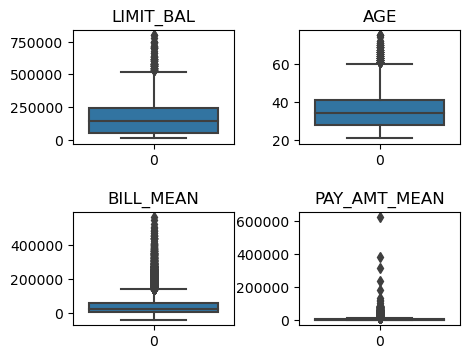

In [11]:
# Make a boxplot for numerical variable
plt.figure(figsize=(5, 18))
plt.subplots_adjust(hspace=0.6,wspace=0.4)
for n, feature in enumerate(numerical):
    ax = plt.subplot(8, 2, n + 1)
    sns.boxplot(X_train[feature])
    plt.title(feature)

Looking at the data are skewed and have so many outliers, it would better for us to use decision tree algorithm like xgboost so we don't need to do normalization and handling the outliers.

### One Hot Encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
ohe = OneHotEncoder(handle_unknown="ignore",drop="first")

In [14]:
# We only one hot encoding sex, marriage,education since in the pay related column we can leave it as it is
X_train_cat = pd.DataFrame(ohe.fit_transform(X_train[["SEX","MARRIAGE","EDUCATION"]]).toarray(),columns=ohe.get_feature_names_out())
X_val_cat = pd.DataFrame(ohe.transform(X_val[["SEX","MARRIAGE","EDUCATION"]]).toarray(),columns=ohe.get_feature_names_out())
X_test_cat = pd.DataFrame(ohe.transform(X_test[["SEX","MARRIAGE","EDUCATION"]]).toarray(),columns=ohe.get_feature_names_out())

In [15]:
X_train = pd.concat([X_train_cat,X_train.drop(["SEX","MARRIAGE","EDUCATION"],axis=1)],axis=1)
X_val = pd.concat([X_val_cat,X_val.drop(["SEX","MARRIAGE","EDUCATION"],axis=1)],axis=1)
X_test = pd.concat([X_test_cat,X_test.drop(["SEX","MARRIAGE","EDUCATION"],axis=1)],axis=1)

# Feature Importance

### Information Gain

In [16]:
from sklearn.feature_selection import mutual_info_classif

In [17]:
mutual_info=mutual_info_classif(X_train,y_train)

mutual_data=pd.Series(mutual_info,index=X_train.columns)
mutual_data.sort_values(ascending=False)

PAY_0                    0.076789
PAY_AMT_MEAN             0.022368
LIMIT_BAL                0.018356
EDUCATION_others         0.008141
EDUCATION_university     0.004426
AGE                      0.004360
SEX_male                 0.004306
BILL_MEAN                0.003989
MARRIAGE_single          0.002820
MARRIAGE_married         0.000000
EDUCATION_high school    0.000000
dtype: float64

- Sex, education, and marriage have low mutual information
- PAY_0 have the highest mutual information followed by PAY_AMT_MEAN and LIMIT_BAL

# Handling Imbalanced Dataset

In [18]:
y_train.value_counts()/len(y_train)

0    0.780476
1    0.219524
Name: DEFAULTED, dtype: float64

We have 78-22 target variable so we use smotetomek to handle it

In [19]:
from imblearn.combine import SMOTETomek
from collections import Counter

In [20]:
os=SMOTETomek()
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 9834, 1: 2766})
The number of classes after fit Counter({0: 8600, 1: 8600})


# Model

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

Since the data is imbalanced we only use confusion matrix and classification report to evaluate our model

In [22]:
ensemble = XGBClassifier()
ensemble.fit(X_train,y_train)
y_pred = ensemble.predict(X_train)

In [23]:
def output_result(y,y_pred):
    print('Confusion Matrix')
    print(confusion_matrix(y,y_pred))
    print(f'Accuracy : {accuracy_score(y,y_pred)}')
    print(f'Auc score Train: {roc_auc_score(y,y_pred)}')
    print(classification_report(y,y_pred))

In [24]:
output_result(y_train,y_pred)

Confusion Matrix
[[9639  195]
 [1359 1407]]
Accuracy : 0.8766666666666667
Auc score Train: 0.7444238127316931
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      9834
           1       0.88      0.51      0.64      2766

    accuracy                           0.88     12600
   macro avg       0.88      0.74      0.78     12600
weighted avg       0.88      0.88      0.86     12600



In [25]:
y_pred = ensemble.predict(X_val)
output_result(y_val,y_pred)

Confusion Matrix
[[3078  189]
 [ 618  315]]
Accuracy : 0.8078571428571428
Auc score Train: 0.6398846695543567
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3267
           1       0.62      0.34      0.44       933

    accuracy                           0.81      4200
   macro avg       0.73      0.64      0.66      4200
weighted avg       0.79      0.81      0.79      4200



Looking at the precision and recall in training and validation evaluation, the models are overfit so we need to tune some parameters.

In [26]:
# Create a pipeline
pipe = Pipeline([("ensemble", XGBClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
               {"ensemble": [XGBClassifier()],
                "ensemble__eta":[0.05,0.01,0.1,0.3],
                "ensemble__max_depth":[3,4,6,10],
                "ensemble__min_child_weight":[1,10,20,30],
               }
]

# Create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) 
best_model = gridsearch.fit(X_train_ns,y_train_ns)

In [27]:
y_pred = best_model.predict(X_train_ns)
output_result(y_train_ns,y_pred)

Confusion Matrix
[[8457  143]
 [ 835 7765]]
Accuracy : 0.9431395348837209
Auc score Train: 0.9431395348837209
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      8600
           1       0.98      0.90      0.94      8600

    accuracy                           0.94     17200
   macro avg       0.95      0.94      0.94     17200
weighted avg       0.95      0.94      0.94     17200



In [28]:
y_pred = best_model.predict(X_val)
output_result(y_val,y_pred)

Confusion Matrix
[[2959  308]
 [ 549  384]]
Accuracy : 0.795952380952381
Auc score Train: 0.6586497342124351
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3267
           1       0.55      0.41      0.47       933

    accuracy                           0.80      4200
   macro avg       0.70      0.66      0.67      4200
weighted avg       0.78      0.80      0.78      4200



Compare to before the model is more consistent and it is not overfit anymore. Since we have imbalanced dataset(target variable), it would be better to look at f1 score and not the accuracy.

# Feature Selection

We already try to calculate information gain and we get that there is feature that have 0 information gain so we want to remove the columns and compare the result.

In [29]:
X_train_ns

,SEX_male,MARRIAGE_married,MARRIAGE_single,EDUCATION_high school,EDUCATION_others,EDUCATION_university,LIMIT_BAL,AGE,PAY_0,BILL_MEAN,PAY_AMT_MEAN
0,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,290000,45,0,86894.500000,4000.000000
1,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,20000,39,0,629.666667,783.333333
2,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,170000,39,0,20534.666667,1120.166667
3,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,110000,24,1,40960.500000,13272.500000
4,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,490000,28,0,95543.166667,17300.000000
...,...,...,...,...,...,...,...,...,...,...,...
17195,0.000000,0.727819,0.272181,0.727819,0.0,0.272181,60000,33,1,49360.880790,1581.360903
17196,0.238698,0.000000,1.000000,0.000000,0.0,0.238698,100000,28,1,35.654311,35.654311
17197,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,160000,25,2,160662.489007,5568.935927
17198,0.309523,0.000000,1.000000,0.000000,0.0,0.690477,120000,27,0,1339.963568,1134.856832


In [30]:
features = X_train.columns[(mutual_data.values!=0)]
X_train_ns = X_train_ns[features]
X_val = X_val[features]
X_test = X_test[features]

In [31]:
# Create a pipeline
pipe = Pipeline([("ensemble", XGBClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
               {"ensemble": [XGBClassifier()],
                "ensemble__eta":[0.05,0.01,0.1,0.3],
                "ensemble__max_depth":[3,4,6,10],
                "ensemble__min_child_weight":[1,10,20,30],
               }
]

# Create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) 
best_model = gridsearch.fit(X_train_ns,y_train_ns)

In [32]:
y_pred = best_model.predict(X_train_ns)
output_result(y_train_ns,y_pred)

Confusion Matrix
[[8591    9]
 [ 235 8365]]
Accuracy : 0.9858139534883721
Auc score Train: 0.985813953488372
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8600
           1       1.00      0.97      0.99      8600

    accuracy                           0.99     17200
   macro avg       0.99      0.99      0.99     17200
weighted avg       0.99      0.99      0.99     17200



In [33]:
y_pred = best_model.predict(X_val)
output_result(y_val,y_pred)

Confusion Matrix
[[2925  342]
 [ 552  381]]
Accuracy : 0.7871428571428571
Auc score Train: 0.6518384665125385
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3267
           1       0.53      0.41      0.46       933

    accuracy                           0.79      4200
   macro avg       0.68      0.65      0.66      4200
weighted avg       0.77      0.79      0.78      4200



After removing some features, there is not much of a difference result. Based on the project, we should look at recall metrics since we need to properly identify all of the defaulter correctly. We can adjust the threshold to get better recall

In [34]:
for t in [0.4,0.45,0.5,0.55]:
    print('Threshold: ',t)
    print('Training')
    y_pred = best_model.predict_proba(X_train_ns)
    pred = (y_pred>=t).astype('int')[:,1]
    output_result(y_train_ns,pred)
    print('Validation')
    y_pred = best_model.predict_proba(X_val)
    pred = (y_pred>=t).astype('int')[:,1]
    output_result(y_val,pred)
    print('*'*55)

Threshold:  0.4
Training
Confusion Matrix
[[8540   60]
 [  98 8502]]
Accuracy : 0.9908139534883721
Auc score Train: 0.9908139534883721
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8600
           1       0.99      0.99      0.99      8600

    accuracy                           0.99     17200
   macro avg       0.99      0.99      0.99     17200
weighted avg       0.99      0.99      0.99     17200

Validation
Confusion Matrix
[[2781  486]
 [ 490  443]]
Accuracy : 0.7676190476190476
Auc score Train: 0.6630260512166388
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3267
           1       0.48      0.47      0.48       933

    accuracy                           0.77      4200
   macro avg       0.66      0.66      0.66      4200
weighted avg       0.77      0.77      0.77      4200

*******************************************************
Threshold:  0.45
Training
Confusio

We will choose 0.4 for the threshold so we can get a better recall.

In [35]:
y_pred = best_model.predict_proba(X_test)
pred = (y_pred>=t).astype('int')[:,1]
output_result(y_test,pred)    

Confusion Matrix
[[2987  267]
 [ 599  347]]
Accuracy : 0.7938095238095239
Auc score Train: 0.6423773764863802
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3254
           1       0.57      0.37      0.44       946

    accuracy                           0.79      4200
   macro avg       0.70      0.64      0.66      4200
weighted avg       0.77      0.79      0.78      4200



# Save the Model

In [36]:
import pickle
import joblib

In [37]:
with open('model.pkl','wb') as f_out:
    pickle.dump((best_model),f_out)

In [38]:
with open('encoder.joblib','wb') as f_out:
    joblib.dump((ohe),f_out)

In [40]:
X_train

,SEX_male,MARRIAGE_married,MARRIAGE_single,EDUCATION_high school,EDUCATION_others,EDUCATION_university,LIMIT_BAL,AGE,PAY_0,BILL_MEAN,PAY_AMT_MEAN
0,1.0,0.0,1.0,0.0,0.0,0.0,20000,28,0,7822.333333,1584.166667
1,0.0,1.0,0.0,0.0,0.0,1.0,290000,45,0,86894.500000,4000.000000
2,1.0,1.0,0.0,0.0,0.0,0.0,20000,39,0,629.666667,783.333333
3,0.0,1.0,0.0,0.0,0.0,1.0,170000,39,0,20534.666667,1120.166667
4,0.0,1.0,0.0,0.0,0.0,1.0,110000,24,1,40960.500000,13272.500000
...,...,...,...,...,...,...,...,...,...,...,...
12595,1.0,0.0,1.0,0.0,0.0,1.0,210000,35,0,139461.833333,5536.166667
12596,1.0,0.0,1.0,0.0,0.0,0.0,50000,29,2,47978.333333,2034.166667
12597,0.0,0.0,1.0,0.0,0.0,0.0,340000,36,0,83341.500000,18300.500000
12598,1.0,0.0,1.0,0.0,0.0,0.0,100000,27,1,100296.833333,7964.333333
